<a href="https://colab.research.google.com/github/kay-squared/PyTorchLearn/blob/main/03_PyTorch_NN_ComputerVision_Video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 03. Computer Vision with PyTorch

Resources:

https://www.learnpytorch.io/03_pytorch_computer_vision/

https://github.com/mrdbourke/pytorch-deep-learning/blob/main/03_pytorch_computer_vision.ipynb

Questions in https://github.com/mrdbourke/pytorch-deep-learning/discussions

Computer vision can be used for 
* binary classification
* multiclass classification (e.g. nutrify)
* object detection
* segmentation (apple fotos: https://machinelearning.apple.com/research/panoptic-segmentation or tesla computer vision, e.g. https://www.youtube.com/watch?v=Vz6yw7iGzZM)
* ...

What we will cov er
* get a dataset (torchvision.datasets)
* architecture of a CNN
* end-to-end multiclass image classification



## Input Data

Typical: 24-bit rgb images (3 times 8-bit)

```
[[red1,red2,...,redn],[g1,g2,...,],[b1, b2, ...,bn]]
```
**One Image** is often represented by the input tensor of shape **NHWC**

```
Shape_input = [batch_size, width, height, color_channels]
```
However, the pytorch library currently expects a different representation: **NCHW** which puts the color channels before width and height !!
```
Shape_input = [batch_size, color_channels, width, height]
```



## Output Data

```
[[prob_pizza_1,prob_sushi_1,...,prob_food_1],[prob_pizza_2,prob_sushi_2,...,prob_food_2],[prob_pizza_m,prob_sushi_m,...,prob_food_m]]
```
**One Image** is represented by a tensor of shape


```
Shape=[number of classes]
```




## CNN Layers

$out(N_i, C_{out_j}) = bias(C_{out_j}) + \sum_{k=1}^{C_{in}-1} weight(C_{out,k} * input(N_i,j))$

where $C_{out_j}$ and $C_{in_j}$ are the number of nodes in the input and output layers and $N_i$ seems to refer to a smaple in a batch of size 1. $*$ is the convolution operator.

We will used 
* nn.Conv2d
* nn.ReLU
* nn.MaxPool2d
* nn.Linear as output shape, with an activation sigmoid or softmax

## 0. Computer vision libraries in pytorch

* torchvision
* torchvision.datasets
* torchvision.models
* torchvision.transforms (turn image data into numbers, augmentation, ...)
* torch.utils.data.Dataset - base dataset clsas for Pytorch
* torch.utils.data.Dataloader - creates a python iterable over a dataset 

In [32]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np

print(torch.__version__)
print(torchvision.__version__)


1.13.1+cu116
0.14.1+cu116


## 1. Get a dataset
. 
We are using Fashion MNIST. Could be downloaded from github, but we use built in stuff from torchvision (in turn: comes from imagenet). Check out https://pytorch.org/vision/stable/datasets.html#built-in-datasets and https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST




In [33]:
# Setup Training data
train_data = datasets.FashionMNIST(
    root = 'data', # where to download data to
    train = True, # whether we want the training or the testing dataset
    download = True, 
    transform = ToTensor(),  # or torchvision.transforms.ToTensor()
    target_transform = None  # how do we want to transform the labels

)

test_data = datasets.FashionMNIST(
    root = 'data', # where to download data to
    train = False, # whether we want the training or the testing dataset
    download = True, 
    transform = ToTensor(),  # or torchvision.transforms.ToTensor()
    target_transform = None  # how do we want to transform the labels

)
len(train_data),len(test_data)

(60000, 10000)

### 1.1 Check input and output shapes

In [34]:
# Image as numbers
image, label = train_data[0]
class_names = train_data.classes
print(f'Image size: {image.size()}, Label: {label}')
print(f'Image Labels: {class_names}')


Image size: torch.Size([1, 28, 28]), Label: 9
Image Labels: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


### 1.2 Visualize data

Text(0.5, 1.0, 'Ankle boot')

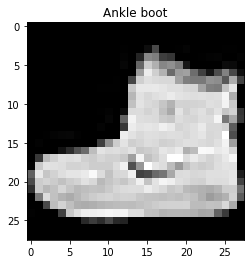

In [39]:
# Image as image
image, label = train_data[0]
# not working:
# plt.imshow(image)
# because it is NCWH


plt.imshow(image.squeeze(),cmap='gray')
plt.title(class_names[label])




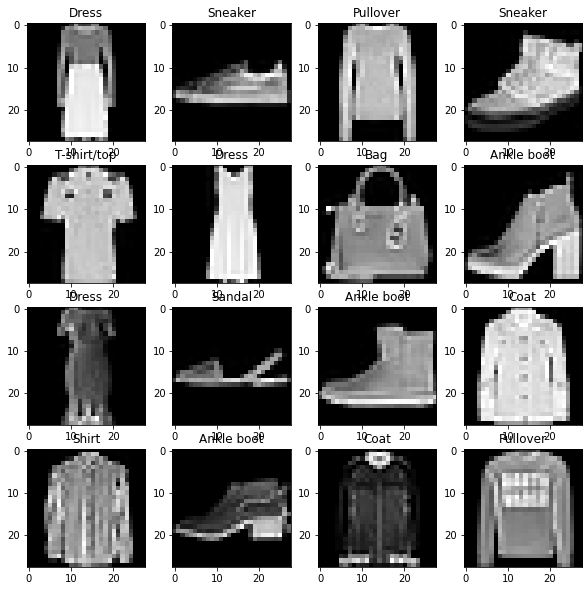

In [47]:
# more images (check out random samples!)
#torch.manual_seed(42)
fig = plt.figure(figsize=(10,10))
rows=4
cols=4
for i in range(1,rows*cols+1):
  random_idx = torch.randint(0,len(train_data),size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows,cols,i)
  plt.imshow(img.squeeze(),cmap='gray')
  plt.title(class_names[label])

tensor([19812])